# DogFaceNet version 7: final version!
IT WORKS!!!

### Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import pickle
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

### Data pre-processing
- Load image and labels
- Training set, validation set (close-set) and testing (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
# Normalization
images /= 255.0


In [5]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

485


### Data augmentation

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    zoom_range=0.1,
    fill_mode='nearest',
    channel_shift_range = 0.1
)

In [22]:
def apply_transform(images, datagen):
    """
    Apply a data preprocessing transformation to images
    Args:
        -images
        -ImageDataGenerator
    Return:
        -a serie of images of the same shape of the input but transformed
    """
    for x in datagen.flow(images, batch_size=len(images)):
        return x

In [7]:
def single_apply_transform(image, datagen):
    """
    Apply a data preprocessing transformation to a single image
    Args:
        -image
        -ImageDataGenerator
    Return:
        -an image of the same shape of the input but transformed
    """
    image_exp = np.expand_dims(image,0)
    for x in datagen.flow(image_exp, batch_size=1):
        return x[0]

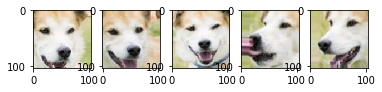

In [21]:
# Test of apply_transform
out = apply_transform(images[:5], datagen)
for i in range(len(out)):
    plt.subplot(1,len(out),i+1)
    plt.imshow(out[i])

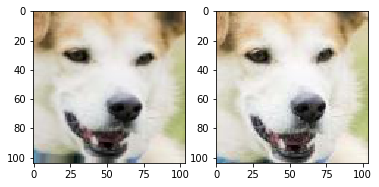

In [150]:
# Test of single_apply_transform
out = single_apply_transform(images[2], datagen)
plt.subplot(1,2,1)
plt.imshow(out)
plt.subplot(1,2,2)
plt.imshow(images[2])

In [ ]:
nbof_repetition = 10

classes = np.unique(labels)
images_aug = np.empty((len(images)*nbof_repetition,h,w,c))
labels_aug = np.empty(len(labels)*nbof_repetition)

count = 0

for i in tqdm_notebook(range(nbof_classes)):
    length = len(labels[np.equal(labels,classes[i])])
    
    for k in range(nbof_repetition):
        for x,y in datagen.flow(images[np.equal(labels,classes[i])],labels[np.equal(labels,classes[i])],batch_size=length,shuffle=False):           
            images_aug[count:count+length] = x
            labels_aug[count:count+length] = y
            break
        count += length

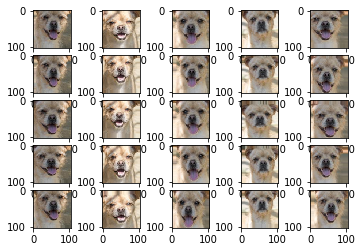

In [36]:
# Test
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images_aug[i]/255)

Open-set: test set

In [8]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

Triplet definition

In [9]:
def define_triplets(images,labels,nbof_triplet = 10000 * 3, datagen=datagen):
    triplet_train = np.empty((nbof_triplet,h,w,c))
    y_triplet = np.empty(nbof_triplet)
    classes = np.unique(labels)
    for i in tqdm_notebook(range(0,nbof_triplet,3)):
        # Pick a class and chose two pictures from this class
        classAP = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classAP)
        keep_classAP = images[keep]
        keep_classAP_idx = labels[keep]
        idx_image1 = np.random.randint(len(keep_classAP))
        idx_image2 = np.random.randint(len(keep_classAP))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(keep_classAP))

        triplet_train[i] = single_apply_transform(keep_classAP[idx_image1],datagen)
        triplet_train[i+1] = single_apply_transform(keep_classAP[idx_image2],datagen)
        y_triplet[i] = keep_classAP_idx[idx_image1]
        y_triplet[i+1] = keep_classAP_idx[idx_image2]
        # Pick a class for the negative picture
        classN = classes[np.random.randint(len(classes))]
        while classN==classAP:
            classN = classes[np.random.randint(len(classes))]
        keep = np.equal(labels,classN)
        keep_classN = images[keep]
        keep_classN_idx = labels[keep]
        idx_image3 = np.random.randint(len(keep_classN))
        triplet_train[i+2] = single_apply_transform(keep_classN[idx_image3],datagen)
        y_triplet[i+2] = keep_classN_idx[idx_image3]
        
    return triplet_train, y_triplet

In [10]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

[412. 412. 231. 412. 412. 231. 412. 412. 115. 129. 129.  90. 129. 129.
  90. 129. 129.  90. 129. 129.  90. 129. 129.  90.]


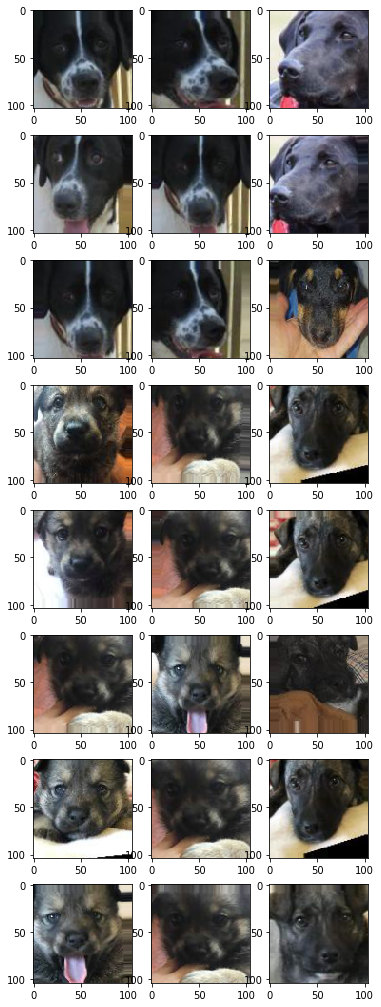

In [79]:
# Test
# Check the triplet
start = 10*3
print(y_triplet_train[start:start+24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_train[i+start])

[34. 34. 35.  9.  9. 21. 43. 43. 45. 19. 19. 11. 11. 11. 44.  9.  9. 36.
 28. 28. 15. 37. 37. 42.]


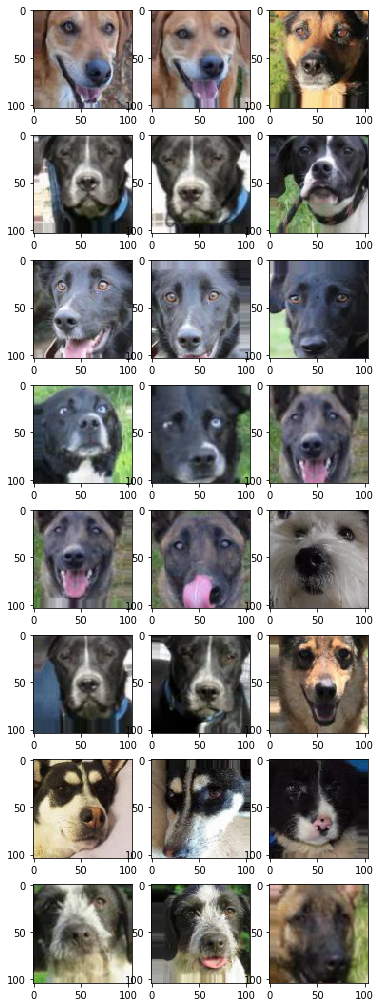

In [76]:
# Test
# Check the triplet
print(y_triplet_test[:24])
plt.figure(figsize=(6,18))
for i in range(0,24):
    plt.subplot(8,3,i+1)
    plt.imshow(triplet_test[i])

### Loss definition

In [13]:
alpha = 1.
def cos_triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5

    return tf.nn.relu(ap - an + alpha)

In [10]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

In [13]:
# The following version was found in a blog post
from triplet_loss import batch_all_triplet_loss, batch_hard_triplet_loss
def triplet(y_true,y_pred):
    y_true = y_true[:,0]
    y_true = tf.reshape(y_true,[-1])
#     loss,_ = batch_all_triplet_loss(y_true,y_pred,1.)
    loss = batch_hard_triplet_loss(y_true,y_pred,1.)
    return loss

### Metric definition

In [27]:
def cos_triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(a*p,-1) * 0.5 + 0.5
    an = K.sum(a*n,-1) * 0.5 + 0.5
    
    return K.less(ap,an)

In [11]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Model definition

In [10]:
# dogfacenet_v6
emb_size = 18

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 128)       0         
__________

In [170]:
# dogfacenet_v9
emb_size = 20

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 104, 104, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 104, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 52, 52, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
__________

In [39]:
# dogfacenet_v11
emb_size = 16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(104, 104, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1)))

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 104, 104, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 104, 104, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 52, 52, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
__________

In [30]:
# Transfer learning
base = tf.keras.Model(model.layers[0].input, model.layers[20].output)
x = Dense(512, activation='relu')(base.output)
x = Dropout(0.5)(x)
x = Dense(16)(x)
x = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model2 = tf.keras.Model(base.layers[0].input, x)


for layer in model2.layers[:21]:
    layer.trainable=True

model2.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model2.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    (None, 104, 104, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 104, 104, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 104, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 52, 52, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
__________

In [12]:
model = tf.keras.models.load_model(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.5.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [21]:
model.save(PATH_MODEL + '2019.02.12.hard_triplet_trained.data_aug.0.h5')

In [13]:
#triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)

In [23]:
for i in range(5):
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

    model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = 1,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )

    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.'+str(i+16)+'.h5')

204


210


267


201


189


165


252


156


273


231


198


213


183


153


192


153


177


255


207


168


189


153


207


168


159


261


150


153


234


309


156


159


195


189


183


222


150


183


180


186


210


171


165


171



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 98s 4ms/step - loss: 0.6536 - triplet_acc: 0.8734 - val_loss: 0.7448 - val_triplet_acc: 0.8870


156


150


168


168


240


183


144


147


243


213


228


231


198


162


162


204


204


231


192


153


165


192


168


216


270


189


312


204


129


270


189


162


171


255


168


237


336


156


135


153


198


141


222


135



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 98s 4ms/step - loss: 0.7502 - triplet_acc: 0.8619 - val_loss: 0.5926 - val_triplet_acc: 0.9050


306


189


162


156


192


171


189


174


225


174


273


207


201


177


195


204


231


258


207


165


150


165


147


177


228


171


210


186


231


165


144


156


180


312


204


126


270


159


153


294


213


204


156


93



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 98s 4ms/step - loss: 0.8285 - triplet_acc: 0.8545 - val_loss: 0.7245 - val_triplet_acc: 0.8870


186


183


168


162


210


165


117


222


174


165


162


144


174


162


276


168


165


234


225


177


267


225


138


129


210


174


288


150


231


198


141


180


195


189


177


246


144


276


216


195


345


189


231


177



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 98s 4ms/step - loss: 0.7967 - triplet_acc: 0.8571 - val_loss: 0.7466 - val_triplet_acc: 0.8960


180


156


135


222


171


249


267


237


249


159


249


159


174


159


147


192


201


195


198


138


174


177


192


147


315


153


180


162


243


216


177


225


144


165


171


270


252


309


234


183


180


174


159


111



Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 98s 4ms/step - loss: 0.7274 - triplet_acc: 0.8676 - val_loss: 0.6582 - val_triplet_acc: 0.8990


In [18]:
new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
predict_train=model.predict(new_images_train)
triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

186


189


132


174


225


147


225


168


156


219


162


135


195


276


186


174


240


237


222


204


201


240


201


147


336


150


144


222


183


201


147


225


177


177


180


180


279


225


162


231


165


210


171


144


In [19]:
history=model.fit(
    triplet_train,
    y_triplet_train,
    batch_size = 21*3,
    epochs = 1,
    validation_data=(triplet_test,y_triplet_test),
    shuffle=False
)

Train on 21750 samples, validate on 3000 samples
Epoch 1/1
21750/21750 [==============================] - 102s 5ms/step - loss: 1.3216 - triplet_acc: 0.7920 - val_loss: 0.7375 - val_triplet_acc: 0.8730


In [20]:
model.save(PATH_MODEL + '2019.02.14.dogfacenet_v11.hard_triplet_trained.data_aug.6.h5')

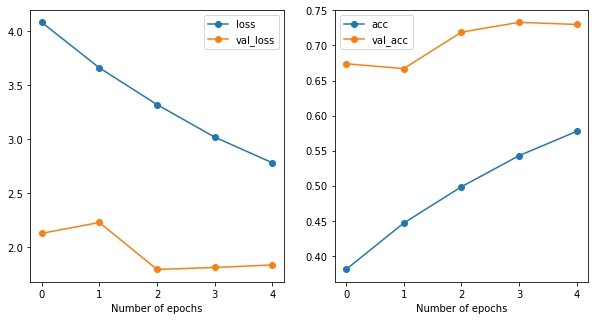

In [22]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

loss = np.append(loss,history.history['loss'])
val_loss = np.append(val_loss,history.history['val_loss'])
acc = np.append(acc,history.history['triplet_acc'])
val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.12.dogfacenet_v6.hard_triplet.data_aug.0.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [28]:
histories = []
nbof_cycles = 9
for i in range(0,nbof_cycles,1):

    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 21*3,
        epochs = nbof_cycles-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    
    histories += [history]
    model.save(PATH_MODEL + '2019.02.14.dogfacenet_v10.hard_triplet_trained.data_aug.' + str(i+1) + '.h5')
    
    new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
    predict_train=model.predict(new_images_train)
    triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

Train on 21750 samples, validate on 3000 samples
Epoch 1/9
21750/21750 [==============================] - 97s 4ms/step - loss: 3.7400 - triplet_acc: 0.4556 - val_loss: 1.5273 - val_triplet_acc: 0.6890
Epoch 2/9
21750/21750 [==============================] - 97s 4ms/step - loss: 2.6973 - triplet_acc: 0.5666 - val_loss: 1.4910 - val_triplet_acc: 0.7060
Epoch 3/9
21750/21750 [==============================] - 97s 4ms/step - loss: 2.2340 - triplet_acc: 0.6290 - val_loss: 1.3709 - val_triplet_acc: 0.7340
Epoch 4/9
21750/21750 [==============================] - 97s 4ms/step - loss: 2.0242 - triplet_acc: 0.6714 - val_loss: 1.4656 - val_triplet_acc: 0.7620
Epoch 5/9
21750/21750 [==============================] - 97s 4ms/step - loss: 1.8040 - triplet_acc: 0.7065 - val_loss: 1.5228 - val_triplet_acc: 0.7680
Epoch 6/9
21750/21750 [==============================] - 97s 4ms/step - loss: 1.6021 - triplet_acc: 0.7348 - val_loss: 1.4158 - val_triplet_acc: 0.7510
Epoch 7/9
21750/21750 [================

162


201


174


192


267


180


177


186


267


177


156


162


153


174


228


171


165


246


246


165


240


183


204


162


219


228


225


171


162


282


153


159


288


171


174


147


153


228


351


171


147


180


177


126



Train on 21750 samples, validate on 3000 samples
Epoch 1/8
21750/21750 [==============================] - 97s 4ms/step - loss: 3.0108 - triplet_acc: 0.5659 - val_loss: 1.4007 - val_triplet_acc: 0.7330
Epoch 2/8
21750/21750 [==============================] - 97s 4ms/step - loss: 2.0703 - triplet_acc: 0.6654 - val_loss: 1.3592 - val_triplet_acc: 0.7800
Epoch 3/8
21750/21750 [==============================] - 97s 4ms/step - loss: 1.8393 - triplet_acc: 0.7023 - val_loss: 1.4137 - val_triplet_acc: 0.7690
Epoch 4/8
21750/21750 [==============================] - 97s 4ms/step - loss: 1.6979 - triplet_acc: 0.7246 - val_loss: 1.6152 - val_triplet_acc: 0.7520
Epoch 5/8
21750/21750 [==============================] - 97s 4ms/step - loss: 1.4691 - triplet_acc: 0.7552 - val_loss: 1.4966 - val_triplet_acc: 0.7790
Epoch 6/8
21750/21750 [==============================] - 97s 4ms/step - loss: 1.3373 - triplet_acc: 0.7720 - val_loss: 1.3645 - val_triplet_acc: 0.7990
Epoch 7/8
21750/21750 [===============

192


246


303


183


204


156


171


165


189


291


156


132


171


177


183


243


153


159


183


168


198


210


183


132


165


180


156


237


189


189


258


171


282


195


204


171


204


255


186


327


186


159


177


111



Train on 21750 samples, validate on 3000 samples
Epoch 1/7
21750/21750 [==============================] - 97s 4ms/step - loss: 2.6721 - triplet_acc: 0.6197 - val_loss: 1.2940 - val_triplet_acc: 0.7610
Epoch 2/7
21750/21750 [==============================] - 98s 4ms/step - loss: 1.7915 - triplet_acc: 0.7132 - val_loss: 1.0345 - val_triplet_acc: 0.7950
Epoch 3/7
21750/21750 [==============================] - 97s 4ms/step - loss: 1.4427 - triplet_acc: 0.7505 - val_loss: 1.1354 - val_triplet_acc: 0.7840
Epoch 4/7
21750/21750 [==============================] - 97s 4ms/step - loss: 1.2678 - triplet_acc: 0.7837 - val_loss: 1.0859 - val_triplet_acc: 0.8170
Epoch 5/7
21750/21750 [==============================] - 97s 4ms/step - loss: 1.0441 - triplet_acc: 0.8177 - val_loss: 1.0386 - val_triplet_acc: 0.8060
Epoch 6/7
21750/21750 [==============================] - 97s 4ms/step - loss: 0.9565 - triplet_acc: 0.8301 - val_loss: 1.0410 - val_triplet_acc: 0.8280
Epoch 7/7
21750/21750 [===============

288


189


258


153


189


183


204


162


150


156


165


171


192


177


171


138


177


270


186


198


162


201


177


279


216


192


201


234


222


141


240


162


159


237


240


186


300


189


153


201


168


156


225


132



Train on 21750 samples, validate on 3000 samples
Epoch 1/6
21750/21750 [==============================] - 97s 4ms/step - loss: 2.5400 - triplet_acc: 0.6422 - val_loss: 1.2240 - val_triplet_acc: 0.7700
Epoch 2/6
21750/21750 [==============================] - 97s 4ms/step - loss: 1.7750 - triplet_acc: 0.7109 - val_loss: 1.3083 - val_triplet_acc: 0.7860
Epoch 3/6
21750/21750 [==============================] - 97s 4ms/step - loss: 1.4509 - triplet_acc: 0.7561 - val_loss: 1.3065 - val_triplet_acc: 0.7960
Epoch 4/6
21750/21750 [==============================] - 97s 4ms/step - loss: 1.1703 - triplet_acc: 0.7941 - val_loss: 1.2667 - val_triplet_acc: 0.7990
Epoch 5/6
21750/21750 [==============================] - 97s 4ms/step - loss: 1.0591 - triplet_acc: 0.8114 - val_loss: 1.2285 - val_triplet_acc: 0.8240
Epoch 6/6
21750/21750 [==============================] - 97s 4ms/step - loss: 0.9623 - triplet_acc: 0.8371 - val_loss: 1.1926 - val_triplet_acc: 0.8060


255


243


165


252


150


264


183


201


153


189


273


177


183


123


141


228


168


231


255


186


183


225


219


213


210


180


216


243


252


162


168


135


156


171


153


192


276


153


153


243


198


150


168


111



Train on 21750 samples, validate on 3000 samples
Epoch 1/5
21750/21750 [==============================] - 97s 4ms/step - loss: 2.4566 - triplet_acc: 0.6440 - val_loss: 1.2365 - val_triplet_acc: 0.7890
Epoch 2/5
21750/21750 [==============================] - 97s 4ms/step - loss: 1.6098 - triplet_acc: 0.7419 - val_loss: 1.1619 - val_triplet_acc: 0.7900
Epoch 3/5
21750/21750 [==============================] - 97s 4ms/step - loss: 1.3033 - triplet_acc: 0.7788 - val_loss: 1.2426 - val_triplet_acc: 0.8040
Epoch 4/5
21750/21750 [==============================] - 97s 4ms/step - loss: 1.0043 - triplet_acc: 0.8221 - val_loss: 1.1575 - val_triplet_acc: 0.8320
Epoch 5/5
21750/21750 [==============================] - 97s 4ms/step - loss: 0.8863 - triplet_acc: 0.8353 - val_loss: 1.1543 - val_triplet_acc: 0.8310


183


153


KeyboardInterrupt: 

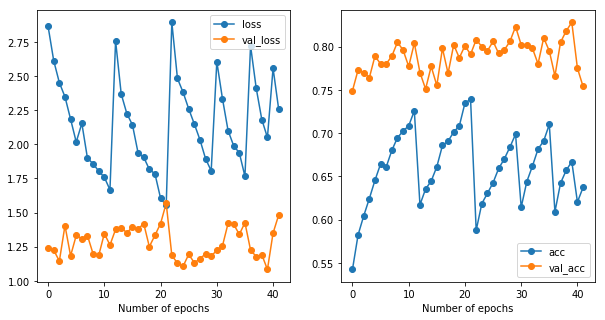

In [156]:
loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for i in range(len(histories)):
    history = histories[i]
    
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])
    
    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.02.13.dogfacenet_v9.hard_triplet.2.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

In [65]:
# Test on new triplet integrity
print(new_y_triplet_train[-30:])
t = np.equal(new_y_triplet_train[0::3],new_y_triplet_train[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

[277. 277. 216. 279. 279. 344.  70.  70. 459. 460. 460. 174. 155. 155.
 104. 427. 427. 235.  89.  89. 274. 458. 458. 397. 454. 454. 484.  81.
  81. 237.]
[ True  True  True ...  True  True  True]


1.0

In [15]:
def shuffle_classes(images,labels):
    """
    Shuffles the classes
    """
    classes = np.unique(labels)
    np.random.shuffle(classes)
    
    shuffled_images = np.empty(images.shape)
    shuffled_labels = np.empty(labels.shape)
    idx = 0
    for i in range(len(classes)):
        keep_classes = np.equal(labels,classes[i])
        length = np.sum(keep_classes.astype(int))
        shuffled_labels[idx:idx+length] = labels[keep_classes]
        shuffled_images[idx:idx+length] = images[keep_classes]
        idx += length
    return shuffled_images, shuffled_labels

In [16]:
def global_define_hard_triplets(images,labels,predict,datagen=datagen):
    """
    Generates hard triplet for offline selection. It will consider the whole dataset.
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict),h,w,c))
    y_triplets = np.empty(3*len(predict))
    
    idx_triplets = 0
    idx_images = 0
    
    for i in range(nbof_classes):
        keep_class = np.equal(labels,classes[i])
        mask_class = np.identity(len(predict)) * keep_class.astype(np.float32)
        
        #predict_class = mask_class.dot(predict)
        predict_other = np.copy(predict)
        for j in range(len(predict)):
            if keep_class[j]:
                predict_other[j] += np.inf
        
        keep_predict_class = predict[keep_class]
        
        for j in range(len(keep_predict_class)):
            # Computes the distance between the current vector and the vectors in the class
            dist_class = np.sum(np.square(keep_predict_class-keep_predict_class[j]),axis=-1)
            
            # Add the anchor
            triplets[idx_triplets] = single_apply_transform(images[idx_images+j],datagen)
            y_triplets[idx_triplets] = labels[idx_images+j]
            
            # Add the hard positive
            triplets[idx_triplets+1] = single_apply_transform(images[idx_images+np.argmax(dist_class)],datagen)
            y_triplets[idx_triplets+1] = labels[idx_images+np.argmax(dist_class)]
            
            # Computes the distance between the current vector and the vectors of the others classes
            dist_other = np.sum(np.square(predict_other-keep_predict_class[j]),axis=-1)
            
            # Add the hard negative
            triplets[idx_triplets+2] = single_apply_transform(images[np.argmin(dist_other)],datagen)
            y_triplets[idx_triplets+2] = labels[np.argmin(dist_other)]
            
            idx_triplets += 3
        
        idx_images += len(keep_predict_class)
        
    return triplets, y_triplets

In [17]:
# Offline triplet selection:
# Generate hard triplets

def define_hard_triplets(images,labels,predict,class_subset_size=10, add=100*3):
    """
    Generates hard triplet for offline selection
    
    Args:
        -images: images from which the triplets will be created
        -labels: labels of the images
        -predict: predicted embeddings for the images by the trained model
        -alpha: threshold of the triplet loss
        -class_subset_class: number of classes in a subset
        -
    Returns:
        -triplet
        -y_triplet: labels of the triplets
    """
    _,idx_classes = np.unique(labels,return_index=True)
    classes = labels[np.sort(idx_classes)]
    nbof_classes = len(classes)
    triplets = np.empty((3*len(predict)+add*(nbof_classes//class_subset_size + 1),h,w,c))
    y_triplets = np.empty(3*len(predict)+add*(nbof_classes//class_subset_size + 1))
    idx = 0
    for i in tqdm_notebook(range(0,len(classes),class_subset_size)):
        selected_classes = classes[i:i+class_subset_size]
        keep_classes = np.array([labels[j] in selected_classes for j in range(len(labels))])
        
        selected_predict = predict[keep_classes]
        length = len(selected_predict)*3
        
        triplets_tmp,y_triplets_tmp = global_define_hard_triplets(
                                                                images[keep_classes],
                                                                labels[keep_classes],
                                                                selected_predict
                                                            )
        print(len(triplets_tmp))
        
        triplets[idx:idx+length] = triplets_tmp
        y_triplets[idx:idx+length] = y_triplets_tmp
        
        triplets[idx+length:idx+length+add], y_triplets[idx+length:idx+length+add] = define_triplets(images, labels, add)
        
        idx += len(triplets_tmp) + add
    return triplets, y_triplets

In [60]:
lez = 30
n_images_train, n_labels_train = shuffle_classes(images_train[:lez],labels_train[:lez])

# Test
predict = model.predict(n_images_train)
# Takes a subset of classes:
_,idx_classes = np.unique(n_labels_train,return_index=True)
classes = n_labels_train[idx_classes]

# step1
selected_classes = classes[0:10]
keep_classes = np.array([n_labels_train[i] in selected_classes for i in range(len(n_labels_train))])

selected_predict = predict[keep_classes]
length = len(selected_predict)

im,lab1 = global_define_hard_triplets(n_images_train[keep_classes],n_labels_train[keep_classes],selected_predict)

In [53]:
n_labels_train

array([52., 52., 52., 52., 52., 51., 51., 51., 51., 51., 51., 51., 53.,
       53., 48., 48., 48., 48., 48., 50., 50., 50., 50., 50., 50., 49.,
       49., 49., 49., 49.])

In [44]:
len(im)

165

In [45]:
len(predict[keep_classes])

55

In [41]:
t

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [61]:
print(lab1[-30:])
t = np.equal(lab1[0::3],lab1[1::3])
print(t)
np.sum(t.astype(np.float32))/len(t)

[52. 52. 51. 52. 52. 51. 53. 53. 50. 53. 53. 50. 50. 50. 51. 50. 50. 48.
 50. 50. 48. 50. 50. 51. 50. 50. 53. 50. 50. 49.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


1.0

In [93]:
histories = []
n = 4
for i in range(n):
    history=model.fit(
        triplet_train,
        y_triplet_train,
        batch_size = 24*3,
        epochs = n-i,
        validation_data=(triplet_test,y_triplet_test),
        shuffle=False
    )
    histories += [history]
    triplet_train, y_triplet_train = define_triplets(images_train,labels_train)
    triplet_test, y_triplet_test = define_triplets(images_test,labels_test,1000*3)
    

Train on 30000 samples, validate on 3000 samples
Epoch 1/4
30000/30000 [==============================] - 119s 4ms/step - loss: 7.0979 - triplet_acc: 0.0571 - val_loss: 4.0956 - val_triplet_acc: 0.3310
Epoch 2/4
30000/30000 [==============================] - 114s 4ms/step - loss: 4.0997 - triplet_acc: 0.4458 - val_loss: 2.5808 - val_triplet_acc: 0.5920
Epoch 3/4
30000/30000 [==============================] - 112s 4ms/step - loss: 2.7597 - triplet_acc: 0.6173 - val_loss: 2.0851 - val_triplet_acc: 0.6410
Epoch 4/4
30000/30000 [==============================] - 113s 4ms/step - loss: 2.1827 - triplet_acc: 0.6947 - val_loss: 1.7840 - val_triplet_acc: 0.7570



Train on 30000 samples, validate on 3000 samples
Epoch 1/3
30000/30000 [==============================] - 112s 4ms/step - loss: 1.9124 - triplet_acc: 0.7291 - val_loss: 1.4763 - val_triplet_acc: 0.7420
Epoch 2/3
30000/30000 [==============================] - 113s 4ms/step - loss: 1.6028 - triplet_acc: 0.7688 - val_loss: 1.6551 - val_triplet_acc: 0.7710
Epoch 3/3
30000/30000 [==============================] - 112s 4ms/step - loss: 1.3242 - triplet_acc: 0.8070 - val_loss: 1.4604 - val_triplet_acc: 0.8150



Train on 30000 samples, validate on 3000 samples
Epoch 1/2
30000/30000 [==============================] - 113s 4ms/step - loss: 1.4515 - triplet_acc: 0.7978 - val_loss: 1.0689 - val_triplet_acc: 0.8290
Epoch 2/2
30000/30000 [==============================] - 112s 4ms/step - loss: 1.2557 - triplet_acc: 0.8194 - val_loss: 1.0898 - val_triplet_acc: 0.8280



Train on 30000 samples, validate on 3000 samples
Epoch 1/1
30000/30000 [==============================] - 113s 4ms/step - loss: 1.2575 - triplet_acc: 0.8183 - val_loss: 0.8215 - val_triplet_acc: 0.8310


In [95]:
model.save(PATH_MODEL+'2019.02.08.dogfacenet_v9.emb_16.h5')

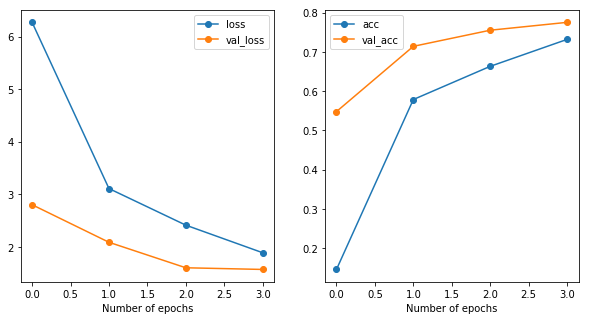

In [75]:
history = histories[0]
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['triplet_acc']
val_acc = history.history['val_triplet_acc']
history_ = np.array([loss,val_loss,acc,val_acc])
# np.save(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.npy',history_)
# np.savetxt(PATH_SAVE+'2018.02.08.dogfacenet_v6.triplet.a_0.3.txt',history_)

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val_loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val_acc")
plt.xlabel("Number of epochs")
plt.legend()

### Evaluate it

#### Evaluate on verification task

In [24]:
# Create pairs
h,w,c = SIZE
pairs = np.empty((len(images_test)*2,h,w,c))
issame = np.empty(len(images_test))
class_test = np.unique(labels_test)
for i in range(len(images_test)):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

[0. 0. 0. 1. 1.]


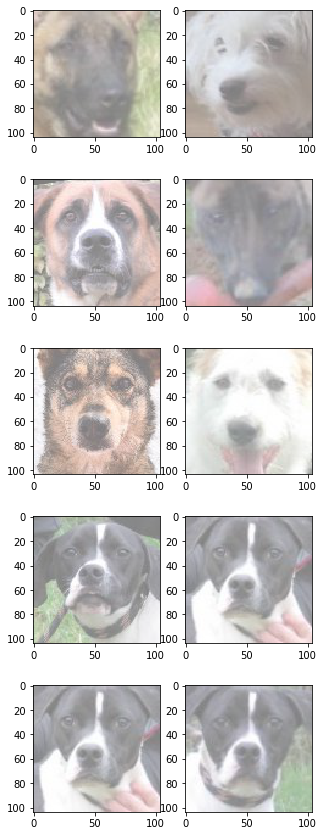

In [44]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [25]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Compute the angle between pairs

best = 0
best_t = 0
thresholds = np.arange(0.0001,4,0.001)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

Best threshold: 1.0691
Best accuracy: 0.9328859060402684


### Face clustering

In [26]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [27]:
len(labels_test)

298

In [28]:
from sklearn.cluster import KMeans

In [29]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=1e-6).fit(predict)

In [30]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

[13. 13. 13. 17. 17. 18. 47.]


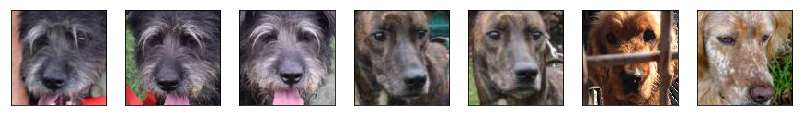

[ 4.  4. 18. 18. 47. 47. 47. 47. 47.]


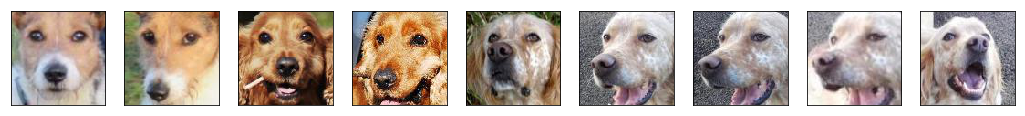

[37. 37. 37. 37. 37.]


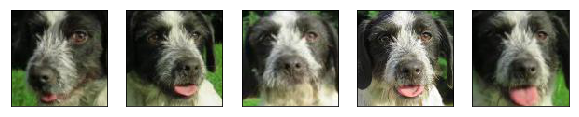

[16. 32.]


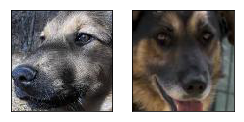

[ 6.  6.  6.  6.  6. 17. 18.]


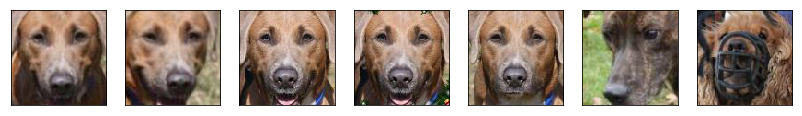

[ 3. 43. 45. 45. 45. 45.]


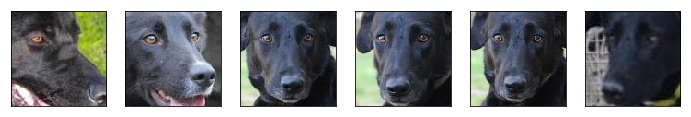

[44. 44. 44. 44. 44.]


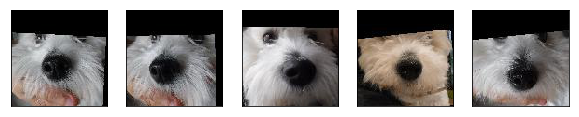

[20. 20. 20. 20. 20. 20.]


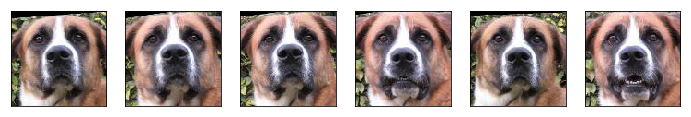

[ 9.  9.  9.  9.  9. 31. 31. 31.]


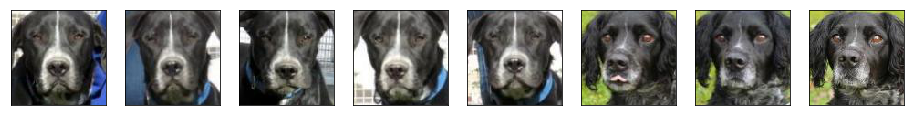

[ 8.  8. 11. 17. 18. 29. 29.]


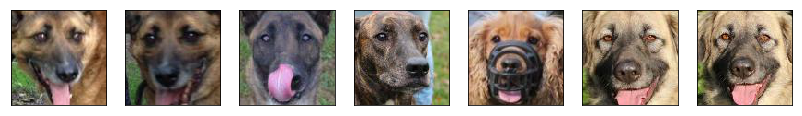

[3. 3. 3. 3. 3.]


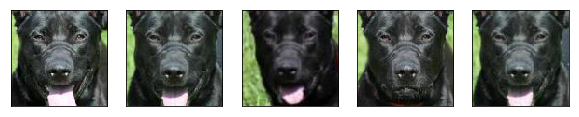

[16. 16. 16. 16. 16. 16. 16. 16. 16.]


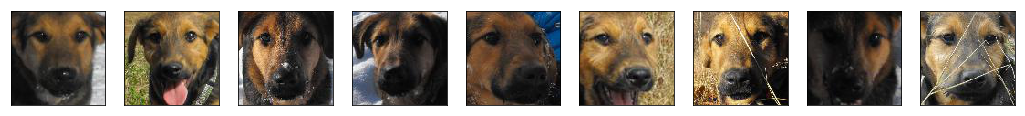

[28. 28. 28. 28. 28. 28. 28. 28. 28. 32. 36. 36.]


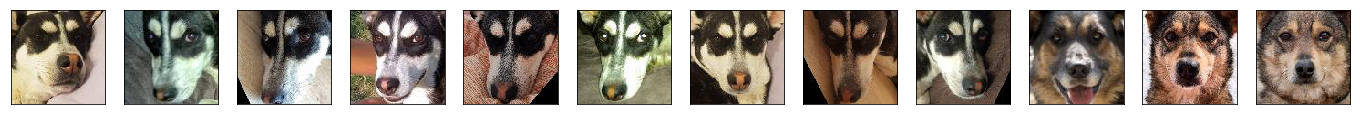

[12. 12. 12. 12. 12. 12. 12. 12. 21. 21. 21. 21. 21.]


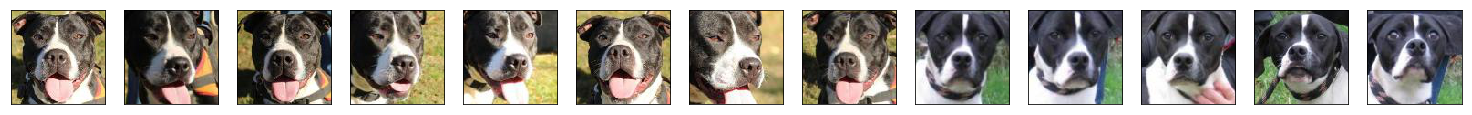

[26. 26. 26. 26. 38. 47.]


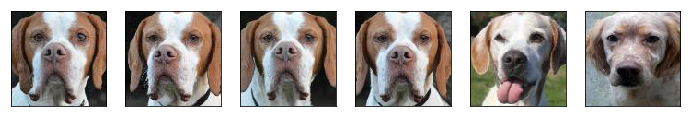

[41. 41. 41. 41. 41. 41.]


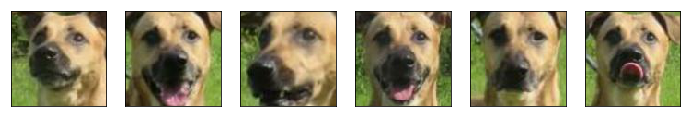

[29. 29. 42. 42. 42.]


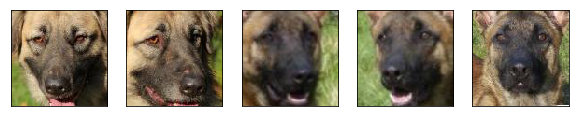

[23. 44. 44. 44. 44.]


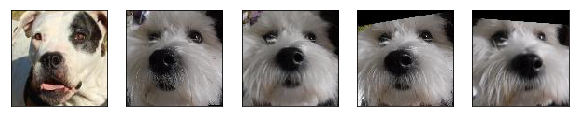

[ 4. 24. 24. 24. 24. 24.]


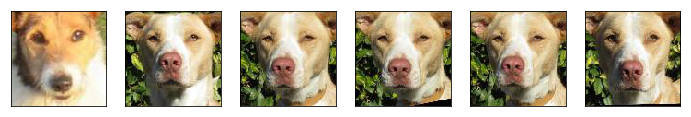

[22. 44. 44. 44. 44. 44. 44. 44. 44.]


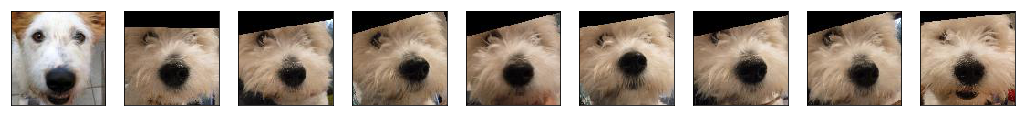

[2. 2.]


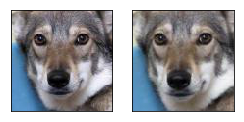

[ 0.  0.  0.  0.  0.  0. 22. 22. 22. 22. 22. 40. 40. 40. 40. 40. 44.]


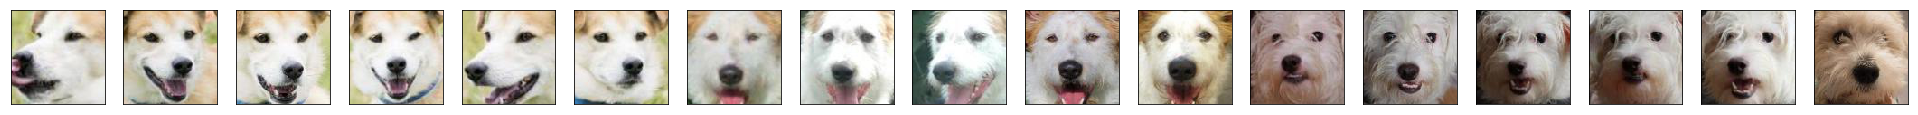

[16. 16. 16. 16. 16. 16. 26. 46.]


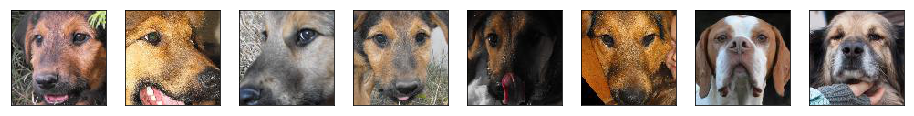

[31. 31. 31. 31.]


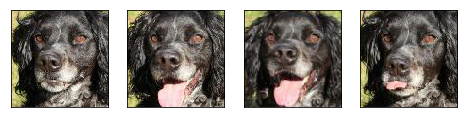

In [31]:
for i in range(24):
    length = len(images_cluster[i])
    print(labels_cluster[i])
    plt.figure(figsize=(length*2,2))
    for j in range(length):
        plt.subplot(1,length,j+1)
        plt.imshow(images_cluster[i][j])
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Recognition

In [32]:
s = 30.
m = 0.3
def cosine(y_true,y_pred):
    
    exp_s = K.exp(s * y_pred)
    exp_s_m = K.exp(s * (y_pred - m))
    
    masked_exp_s_m = exp_s_m * y_true
    
    inv_mask = 1. - y_true
    masked_exp_s = exp_s * inv_mask
    
    den = K.sum(masked_exp_s + masked_exp_s_m, axis=-1, keepdims=True)
    out = masked_exp_s_m / den
    out = K.sum(out,axis=-1)
    ret = - K.log(out)
    ret = K.sum(ret)
    return ret

In [33]:
class Cosine(tf.keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Cosine, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[-1],self.output_dim))

        self.kernel = self.add_weight(name='kernel', 
                                      shape=shape,
                                      initializer='uniform',
                                      trainable=True)
        super(Cosine, self).build(input_shape)

    def call(self, x):
        x = tf.math.l2_normalize(x, axis=-1)
        w = tf.math.l2_normalize(self.kernel, axis=0)
        
        return K.dot(x, w)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [34]:
labels_test_exp = tf.keras.utils.to_categorical(labels_test)

In [37]:
#out = tf.keras.layers.Dense(128, activation='relu')(model.output)
out = Cosine(len(labels_test_exp[0]))(model.output)
#out = tf.keras.layers.Dense(24, activation='softmax')(out)
recog = tf.keras.Model(model.input,out)
for layer in model.layers: layer.trainable = False
recog.compile(tf.keras.optimizers.Adam(),loss=cosine,metrics=['accuracy'])

In [38]:
recog.fit(images_test,labels_test_exp,batch_size=64,epochs=30)

Epoch 1/30
298/298 [==============================] - 2s 6ms/step - loss: 1538.4350 - acc: 0.0268
Epoch 2/30
298/298 [==============================] - 0s 2ms/step - loss: 1354.1154 - acc: 0.0638
Epoch 3/30
298/298 [==============================] - 0s 2ms/step - loss: 1187.7325 - acc: 0.1174
Epoch 4/30
298/298 [==============================] - 0s 2ms/step - loss: 1051.1713 - acc: 0.1443
Epoch 5/30
298/298 [==============================] - 0s 2ms/step - loss: 919.2649 - acc: 0.2315
Epoch 6/30
298/298 [==============================] - 0s 2ms/step - loss: 819.8516 - acc: 0.2852
Epoch 7/30
298/298 [==============================] - 0s 2ms/step - loss: 778.0952 - acc: 0.3289
Epoch 8/30
298/298 [==============================] - 0s 2ms/step - loss: 702.3572 - acc: 0.3859
Epoch 9/30
298/298 [==============================] - 0s 2ms/step - loss: 668.3348 - acc: 0.4060
Epoch 10/30
298/298 [==============================] - 0s 2ms/step - loss: 624.9931 - acc: 0.4698
Epoch 11/30
298/298 [====

### Observation on the heatmap

In [39]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

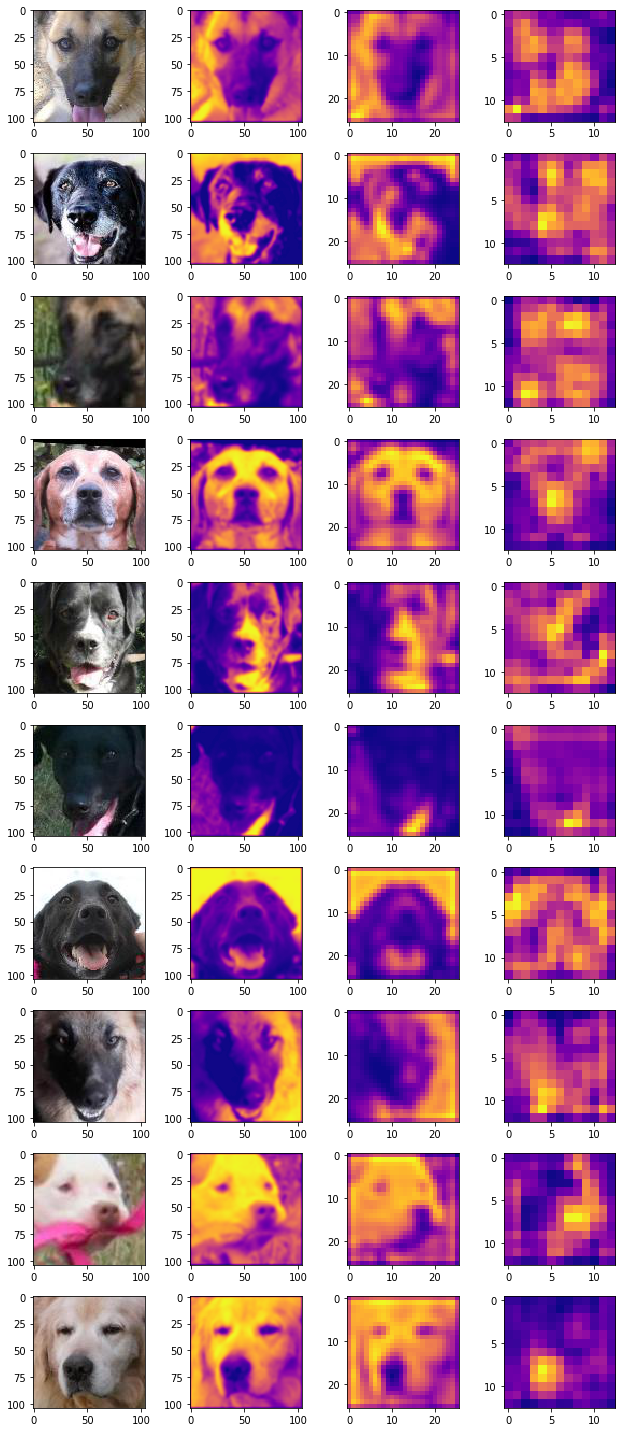

In [44]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

### Archives:

In [12]:
# dogfacenet_v7
out_num = len(unique)

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Lambda

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(104, 104, 3))
x = base_model.output
# x = base_model.layers[8].output
# x = MaxPooling2D((2,2))(x)
# x = Dropout(0.25)(x)
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(18)(x)
x = Lambda(lambda x: tf.math.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=triplet,
              optimizer='rmsprop',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104, 104, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 104, 104, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 104, 104, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 52, 52, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 52, 52, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 52, 52, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 26, 26, 128)       0         
__________

In [17]:
triplet_train_pre = tf.keras.applications.vgg16.preprocess_input(triplet_train)

In [21]:
history=model.fit(
    triplet_train_pre,
    np.zeros((len(triplet_train),18)),
    batch_size = 63,
    epochs = 100,
    validation_split=0.1
)

Train on 27000 samples, validate on 3000 samples
Epoch 1/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2989 - triplet_acc: 0.5084 - val_loss: 6.2688 - val_triplet_acc: 0.6670
Epoch 2/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2962 - triplet_acc: 0.5050 - val_loss: 6.2688 - val_triplet_acc: 0.6750
Epoch 3/100
27000/27000 [==============================] - 74s 3ms/step - loss: 6.2955 - triplet_acc: 0.4880 - val_loss: 6.2688 - val_triplet_acc: 0.6810
Epoch 4/100
27000/27000 [==============================] - 75s 3ms/step - loss: 6.2901 - triplet_acc: 0.4918 - val_loss: 6.2689 - val_triplet_acc: 0.6990
Epoch 5/100
 3591/27000 [==>...........................] - ETA: 1:26 - loss: 6.3122 - triplet_acc: 0.4971

KeyboardInterrupt: 

In [31]:
# dogfacenet_v8 : inspired from FaceNet paper
emb_size = 64

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

model = Sequential()
model.add(Conv2D(64, (5, 5), strides=(2,2), activation='relu', input_shape=(104, 104, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(192, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(384, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(emb_size))
model.add(Lambda(lambda x: tf.nn.l2_normalize(x)))

model.compile(loss=triplet,
              optimizer='adagrad',
              metrics=[triplet_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 50, 50, 64)        4864      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 25, 25, 64)        4160      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 25, 25, 192)       110784    
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 192)       768       
__________

In [13]:
# dogfacenet_v4
out_num = len(unique)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(104, 104, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Cosine(out_num))

model.compile(loss=cosine,
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 102, 102, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 49, 49, 256)       147712    
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 512)       1180160   
__________

In [14]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/12
40/40 [==============================] - ETA: 6:40 - loss: 3033.9841 - acc: 0.0000e+ - ETA: 3:20 - loss: 3193.7477 - acc: 0.0078   - ETA: 2:14 - loss: 3131.7262 - acc: 0.00 - ETA: 1:41 - loss: 3100.9213 - acc: 0.00 - ETA: 1:21 - loss: 3011.6771 - acc: 0.01 - ETA: 1:07 - loss: 2969.4160 - acc: 0.01 - ETA: 57s - loss: 2898.0631 - acc: 0.0089 - ETA: 50s - loss: 2821.5505 - acc: 0.007 - ETA: 44s - loss: 2773.2350 - acc: 0.006 - ETA: 39s - loss: 2718.2655 - acc: 0.006 - ETA: 35s - loss: 2673.9746 - acc: 0.005 - ETA: 32s - loss: 2639.0772 - acc: 0.005 - ETA: 29s - loss: 2607.5262 - acc: 0.004 - ETA: 27s - loss: 2588.1751 - acc: 0.004 - ETA: 24s - loss: 2556.4133 - acc: 0.004 - ETA: 22s - loss: 2525.0515 - acc: 0.004 - ETA: 21s - loss: 2379.7240 - acc: 0.004 - ETA: 19s - loss: 2365.8392 - acc: 0.004 - ETA: 18s - loss: 2358.0670 - acc: 0.004 - ETA: 16s - loss: 2344.6071 - acc: 0.004 - ETA: 15s - loss: 2334.9984 - acc: 0.004 - ETA: 14s - loss: 2315.3236 - acc: 0.004 - ETA: 13s - loss

40/40 [==============================] - ETA: 12s - loss: 1553.2555 - acc: 0.046 - ETA: 11s - loss: 1557.4442 - acc: 0.023 - ETA: 11s - loss: 1559.9218 - acc: 0.020 - ETA: 11s - loss: 1564.8853 - acc: 0.019 - ETA: 11s - loss: 1560.9692 - acc: 0.021 - ETA: 10s - loss: 1562.4371 - acc: 0.020 - ETA: 10s - loss: 1563.6058 - acc: 0.017 - ETA: 10s - loss: 1563.6732 - acc: 0.019 - ETA: 9s - loss: 1562.8299 - acc: 0.019 - ETA: 9s - loss: 1560.2613 - acc: 0.02 - ETA: 9s - loss: 1559.2021 - acc: 0.02 - ETA: 9s - loss: 1559.6456 - acc: 0.02 - ETA: 8s - loss: 1559.8105 - acc: 0.02 - ETA: 8s - loss: 1562.1020 - acc: 0.02 - ETA: 8s - loss: 1564.2353 - acc: 0.02 - ETA: 7s - loss: 1473.9175 - acc: 0.01 - ETA: 6s - loss: 1479.2918 - acc: 0.01 - ETA: 6s - loss: 1484.0584 - acc: 0.01 - ETA: 6s - loss: 1487.1040 - acc: 0.01 - ETA: 5s - loss: 1490.0914 - acc: 0.02 - ETA: 5s - loss: 1493.1654 - acc: 0.02 - ETA: 5s - loss: 1496.8550 - acc: 0.02 - ETA: 5s - loss: 1499.7177 - acc: 0.02 - ETA: 4s - loss: 1503.3

In [41]:
model.save('../output/model/dogfacenet_v6_cosine.h5')

### Train it

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(1e-5),
              metrics=['accuracy'])

In [18]:
model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 50,
    validation_data=(images_valid,labels_valid)
)

Epoch 1/50


c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\guillaume\anaconda3\lib\site-packages\keras_preprocessing\image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


13/13 [==============================] - ETA: 1:29 - loss: 4.8474 - acc: 0.0000e+0 - ETA: 41s - loss: 4.8427 - acc: 0.0156    - ETA: 25s - loss: 4.8440 - acc: 0.01 - ETA: 17s - loss: 4.8413 - acc: 0.01 - ETA: 12s - loss: 4.8375 - acc: 0.01 - ETA: 9s - loss: 4.8348 - acc: 0.0140 - ETA: 6s - loss: 4.8315 - acc: 0.016 - ETA: 5s - loss: 4.8274 - acc: 0.014 - ETA: 3s - loss: 4.8269 - acc: 0.018 - ETA: 2s - loss: 4.8270 - acc: 0.020 - ETA: 1s - loss: 4.8270 - acc: 0.021 - ETA: 0s - loss: 4.8276 - acc: 0.021 - 9s 674ms/step - loss: 4.8283 - acc: 0.0221 - val_loss: 4.8029 - val_acc: 0.0290
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 4.7678 - acc: 0.062 - ETA: 0s - loss: 4.7703 - acc: 0.039 - ETA: 0s - loss: 4.7796 - acc: 0.031 - ETA: 1s - loss: 4.7835 - acc: 0.027 - ETA: 0s - loss: 4.7769 - acc: 0.031 - ETA: 0s - loss: 4.7819 - acc: 0.026 - ETA: 0s - loss: 4.7791 - acc: 0.026 - ETA: 0s - loss: 4.7824 - acc: 0.027 - ETA: 0s - loss: 4.7803 - acc: 0.024 - ETA: 0s - loss: 4

Epoch 15/50
13/13 [==============================] - ETA: 1s - loss: 4.5012 - acc: 0.125 - ETA: 1s - loss: 4.4540 - acc: 0.125 - ETA: 1s - loss: 4.4515 - acc: 0.125 - ETA: 1s - loss: 4.4257 - acc: 0.148 - ETA: 1s - loss: 4.4377 - acc: 0.140 - ETA: 1s - loss: 4.4397 - acc: 0.140 - ETA: 0s - loss: 4.4405 - acc: 0.147 - ETA: 0s - loss: 4.4501 - acc: 0.144 - ETA: 0s - loss: 4.4489 - acc: 0.147 - ETA: 0s - loss: 4.4454 - acc: 0.150 - ETA: 0s - loss: 4.4487 - acc: 0.149 - ETA: 0s - loss: 4.4516 - acc: 0.145 - 2s 172ms/step - loss: 4.4499 - acc: 0.1480 - val_loss: 4.3780 - val_acc: 0.1594
Epoch 16/50
13/13 [==============================] - ETA: 2s - loss: 4.4242 - acc: 0.156 - ETA: 2s - loss: 4.4119 - acc: 0.156 - ETA: 1s - loss: 4.4161 - acc: 0.166 - ETA: 1s - loss: 4.4338 - acc: 0.164 - ETA: 1s - loss: 4.4340 - acc: 0.175 - ETA: 1s - loss: 4.4467 - acc: 0.161 - ETA: 1s - loss: 4.4539 - acc: 0.151 - ETA: 1s - loss: 4.4572 - acc: 0.152 - ETA: 0s - loss: 4.4554 - acc: 0.152 - ETA: 0s - loss: 

KeyboardInterrupt: 

In [49]:
model.save('../output/model/small_net_2.h5')